In [36]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [37]:
import numpy as np
import pandas as pd

In [38]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [39]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [40]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [41]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [42]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [43]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [44]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [45]:
inspect = inspect(engine)
inspect.get_table_names()

['measurement', 'station']

In [46]:
columns = inspect.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [47]:
columns = inspect.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

In [48]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
m_results = session.query(Measurement.date, Measurement.prcp).\
order_by(Measurement.date.desc()).all()
m_results_df = pd.DataFrame(m_results)
m_results_df.head()

,date,prcp
0,2017-08-23,0.00
1,2017-08-23,0.00
2,2017-08-23,0.08
3,2017-08-23,0.45
4,2017-08-22,0.00


In [49]:
m_results_df['date'] = m_results_df['date'].str.replace("-","").astype(int)

m_results_df.head()

In [52]:

m_results_df.head()

,date,prcp
0,20170823,0.00
1,20170823,0.00
2,20170823,0.08
3,20170823,0.45
4,20170822,0.00


In [53]:
precip_12_df = m_results_df[(m_results_df.date <= 20170823) & (m_results_df.date >= 20160823)]
precip_12_df = precip_12_df.sort_values(by=['date'])
precip_12_df.dropna()


,date,prcp
2229,20160823,0.70
2223,20160823,0.00
2224,20160823,0.15
2228,20160823,1.79
2227,20160823,0.02
2225,20160823,0.05
2222,20160824,1.45
2221,20160824,2.15
2220,20160824,1.22
2218,20160824,2.28


In [56]:

bars = precip_12_df['prcp']
x_axis = np.arange(len(precip_12_df['prcp']))


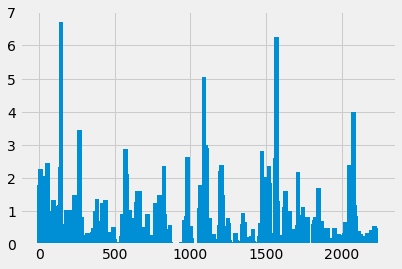

In [59]:
plt.bar(x_axis, bars, width = 30)

# tick_locations = []
# plt.xticks(tick_locations)
# # plt.grid()
# plt.tight_layout()
plt.show()

![precipitation](Images/precipitation.png)

In [20]:
# Use Pandas to calcualte the summary statistics for the precipitation data

![describe](Images/describe.png)

In [21]:
# Design a query to show how many stations are available in this dataset?


In [22]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.


In [23]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?


In [24]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


![precipitation](Images/station-histogram.png)

In [25]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [26]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [27]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [28]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



## Optional Challenge Assignment

In [29]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [30]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [31]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [32]:
# Plot the daily normals as an area plot with `stacked=False`
